In [21]:
pose_3d = "/workspace/data/unity_data/RecordingsPose/male_pose3d_trimmed.jsonl"
pose_2d_left = "/workspace/data/unity_data/RecordingsPose/cam_left camera/male_kpt2d_left camera_trimmed.jsonl"
pose_2d_right = "/workspace/data/unity_data/RecordingsPose/cam_right camera/male_kpt2d_right camera_trimmed.jsonl"

left_video = "/workspace/data/unity_data/Recordings/male/left.mp4"
right_video = "/workspace/data/unity_data/Recordings/male/right.mp4"

sam3d_left_results = "/workspace/data/sam3d_body_results/unity/male/left_sam_3d_body_outputs.npz"
sam3d_right_results = "/workspace/data/sam3d_body_results/unity/male/right_sam_3d_body_outputs.npz"

In [22]:

# 对应 MHR70 标准中的 ID 索引
target_mhr_ids = [0, 1, 2, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 41, 62, 69]

# MHR70 标准 ID 与你的 JSON 骨骼名称映射
# 格式: { MHR70_ID: "Your_JSON_Bone_Name" }
unity_mhr70_mapping = {
    # 0:  "head",           # nose -> 用 head 代替
    1: "Bone_Eye_L",     # left_eye
    2: "Bone_Eye_R",     # right_eye
    5:  "Upperarm_L",     # left_shoulder
    6:  "Upperarm_R",     # right_shoulder
    7:  "lowerarm_l",     # left_elbow
    8:  "lowerarm_r",     # right_elbow
    9:  "Thigh_L",        # left_hip
    10: "Thigh_R",        # right_hip
    11: "calf_l",         # left_knee
    12: "calf_r",         # right_knee
    13: "Foot_L",         # left_ankle
    14: "Foot_R",         # right_ankle
    # 15: "ball_l",         # left_big_toe -> 对应脚掌
    # 18: "ball_r",         # right_big_toe
    41: "Hand_R",         # right_wrist
    62: "Hand_L",         # left_wrist
    69: "neck_01"         # neck
}

# 基于图片连线逻辑的 MHR70 索引对
# 格式: (起点ID, 终点ID, 描述)
mhr70_skeleton_links = [
    # 躯干与头部
    # (69, 0,  "脖子 -> 头部"),
    (69, 5,  "脖子 -> 左肩"),
    (69, 6,  "脖子 -> 右肩"),
    (5,  6,  "左肩 -> 右肩"), # 肩膀横向连线
    
    (5, 1, "左肩 -> 左眼"),  # 左眼连线
    (6, 2, "右肩 -> 右眼"),  # 右眼连线
    (1, 2 , "左眼 -> 右眼"),  # 眼睛横向连线

    # 左半身 (左手)
    (5,  7,  "左肩 -> 左肘"),
    (7,  62, "左肘 -> 左手腕"),
    
    # 右半身 (右手)
    (6,  8,  "右肩 -> 右肘"),
    (8,  41, "右肘 -> 右手腕"),
    
    # 下半身核心 (胯部)
    (9,  10, "左胯 -> 右胯"), # 胯部横向连线
    (5, 9,  "左肩膀 -> 左胯"),
    (6, 10, "右肩膀 -> 右胯"),
    
    # 左腿
    (9,  11, "左胯 -> 左膝"),
    (11, 13, "左膝 -> 左脚踝"),
    # (13, 15, "左脚踝 -> 左脚掌"),
    
    # 右腿
    (10, 12, "右胯 -> 右膝"),
    (12, 14, "右膝 -> 右脚踝"),
    # (14, 18, "右脚踝 -> 右脚掌")
]

In [ ]:
import numpy as np

left_outputs = np.load(sam3d_left_results, allow_pickle=True)['arr_0']
left_outputs = np.load(sam3d_right_results, allow_pickle=True)['arr_0']

ValueError: can only convert an array of size 1 to a Python scalar

In [24]:
for k, v in left_outputs[0].items():
    if isinstance(v, np.ndarray):
        print(f"{k}: ndarray with shape {v.shape}")
    else:
        print(f"{k}: {type(v)}")

bbox: ndarray with shape (4,)
focal_length: <class 'numpy.float32'>
pred_keypoints_3d: ndarray with shape (70, 3)
pred_keypoints_2d: ndarray with shape (70, 2)
pred_vertices: ndarray with shape (18439, 3)
pred_cam_t: ndarray with shape (3,)
pred_pose_raw: ndarray with shape (266,)
global_rot: ndarray with shape (3,)
body_pose_params: ndarray with shape (133,)
hand_pose_params: ndarray with shape (108,)
scale_params: ndarray with shape (28,)
shape_params: ndarray with shape (45,)
expr_params: ndarray with shape (72,)
mask: <class 'NoneType'>
pred_joint_coords: ndarray with shape (127, 3)
pred_global_rots: ndarray with shape (127, 3, 3)
lhand_bbox: ndarray with shape (4,)
rhand_bbox: ndarray with shape (4,)
frame: ndarray with shape (1080, 1920, 3)


In [25]:
import json
import os

def load_all_GT_data(file_path):
    """
    JSONL形式（または1行1JSON形式）のファイルを安全にロードする
    """
    all_frames_data = []
    
    # ファイルが存在するかチェック
    if not os.path.exists(file_path):
        print(f"Error: ファイルが見つかりません -> {file_path}")
        return []

    try:
        with open(file_path, 'r', encoding='utf-8-sig') as f:
            for line_number, line in enumerate(f, 1):
                line = line.strip()
                if not line:
                    continue  # 空行をスキップ
                
                try:
                    # 1行ずつJSONとしてパース
                    frame_data = json.loads(line)
                    all_frames_data.append(frame_data)
                except json.JSONDecodeError as e:
                    print(f"Warning: {line_number}行目の解析に失敗しました: {e}")
                    
        print(f"Successfully loaded {len(all_frames_data)} frames.")
    except Exception as e:
        print(f"Fatal Error: ファイルの読み込み中にエラーが発生しました: {e}")
        
    return all_frames_data

# --- 実行 ---
# pose_2d_left はファイルパス文字列であることを前提としています
pose_2d_left_data = load_all_GT_data(pose_2d_left)
pose_2d_right_data = load_all_GT_data(pose_2d_right)
pose_3d_data = load_all_GT_data(pose_3d)


# 最初のフレームのデータ構造を確認
if pose_2d_left_data:
    print("Keys in first frame:", pose_2d_left_data[0].keys())

Successfully loaded 677 frames.
Successfully loaded 677 frames.
Successfully loaded 677 frames.
Keys in first frame: dict_keys(['frame_idx', 'time', 'camera', 'width', 'height', 'joints2d'])


In [26]:
import numpy as np

frame = left_outputs[0]["frame"]  # 例として左カメラのフレームを使用

v_h, v_w = frame.shape[:2]
print(v_w, v_h)

# 注意：如果 JSON 中没有宽向高度信息，请确保默认值正确
d_w, d_h = pose_2d_left_data[0].get('width', 1920), pose_2d_left_data[0].get('height', 1080)
print(d_w, d_h)
scale_x, scale_y = v_w / d_w, v_h / d_h
print(scale_x, scale_y)

def harmonize_to_pixel_coords(sam3d_raw, unity_raw, mapping_dict, target_ids, width=1920, height=1080, scale_x=1.0, scale_y=1.0):
    """
    Sam3D(ピクセル座標)とUnity(負のピクセル座標)を共通のピクセル座標系に統一する
    """
    unified_sam3d = {}
    unified_unity = {}
    
    # --- 1. Sam3Dデータの統一 (型を float に整理) ---
    sam3d_coords = np.atleast_2d(sam3d_raw.squeeze())
    for i, m_id in enumerate(target_ids):
        if i < len(sam3d_coords):
            # np.float32 を標準の float にキャストしてタプル化
            unified_sam3d[m_id] = (float(sam3d_coords[i][0]), float(sam3d_coords[i][1]))

    # --- 2. Unityデータの統一 (V軸の負の値を補正) ---
    name_to_id = {name: m_id for m_id, name in mapping_dict.items()}
    joints_list = unity_raw.get("joints2d", unity_raw) if isinstance(unity_raw, dict) else unity_raw

    for item in joints_list:
        m_id = name_to_id.get(item['name'])
        if m_id in target_ids:
            # Unityデータがピクセル値で、かつVが負の値(-461.9など)の場合
            # 画像の上端を0とするには絶対値(abs)を取るのが一般的です
            u_px = float(item['u']) * scale_x
            v_px = height - (float(item['v']) * scale_y)
            
            unified_unity[m_id] = (u_px, v_px)
            
    return unified_sam3d, unified_unity

# --- 実行 ---

# データの取得
# left_outputs は NpzFile なので arr_0 等のキーでアクセスが必要な場合があります
sam3d_raw = left_outputs[0]["pred_keypoints_2d"][target_mhr_ids] 
unity_raw = pose_2d_left_data[0]

# 統一処理
sam3d_px, unity_px = harmonize_to_pixel_coords(
    sam3d_raw, 
    unity_raw, 
    unity_mhr70_mapping, 
    target_mhr_ids,
    scale_x=scale_x,
    scale_y=scale_y
)

# 確認
print(f"Unified Sam3D points: {len(sam3d_px)}")
print(f"Unified Unity points: {len(unity_px)}")

if 0 in sam3d_px and 0 in unity_px:
    print(f"ID 0 (Head) - Sam3D Pixel: {sam3d_px[0]}")
    print(f"ID 0 (Head) - Unity Pixel: {unity_px[0]}")

1920 1080
1920 1080
1.0 1.0
Unified Sam3D points: 16
Unified Unity points: 15


In [27]:
sam3d_px, unity_px

({0: (859.9498291015625, 524.8621215820312),
  1: (858.4306640625, 513.0880126953125),
  2: (862.2120971679688, 510.4112243652344),
  5: (919.6473388671875, 516.9096069335938),
  6: (917.4668579101562, 515.3319091796875),
  7: (851.2048950195312, 547.84375),
  8: (859.1315307617188, 545.176513671875),
  9: (1025.8916015625, 604.70458984375),
  10: (1021.4403686523438, 601.8330688476562),
  11: (934.1425170898438, 673.1962280273438),
  12: (932.1018676757812, 664.8419799804688),
  13: (986.3170776367188, 771.375),
  14: (984.271484375, 754.3232421875),
  41: (798.5950317382812, 537.2072143554688),
  62: (785.9497680664062, 540.8883666992188),
  69: (912.3460693359375, 519.195556640625)},
 {5: (916.7213134765625, 522.647216796875),
  7: (844.304443359375, 549.108642578125),
  62: (777.7177124023438, 542.7910766601562),
  6: (919.3836059570312, 524.1099243164062),
  8: (864.4649658203125, 544.967529296875),
  41: (806.3899536132812, 539.610595703125),
  69: (917.3085327148438, 526.1084594

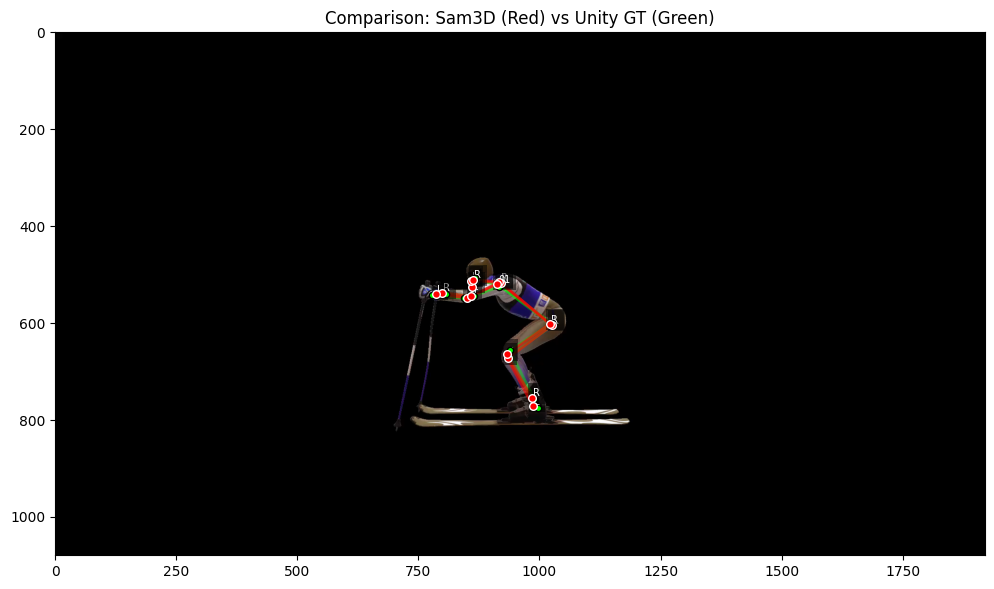

In [28]:
import cv2
import matplotlib.pyplot as plt

def visualize_comparison_final(frame, sam_dict, unity_dict, mapping_dict, skeleton_links, title="Pose Comparison"):
    """
    予測(Sam3D: 赤)と正解(Unity: 緑)を同じ画像に重ねて描画する
    """
    plt.figure(figsize=(12, 8))
    plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

    # --- 1. Unity GT (正解: 緑) の描画 ---
    for start_id, end_id, *info in skeleton_links:
        if start_id in unity_dict and end_id in unity_dict:
            p1, p2 = unity_dict[start_id], unity_dict[end_id]
            plt.plot([p1[0], p2[0]], [p1[1], p2[1]], color='#00FF00', linewidth=2, alpha=0.4)

    # --- 2. Sam3D Prediction (予測: 赤) の描画 ---
    for start_id, end_id, *info in skeleton_links:
        if start_id in sam_dict and end_id in sam_dict:
            p1, p2 = sam_dict[start_id], sam_dict[end_id]
            plt.plot([p1[0], p2[0]], [p1[1], p2[1]], color='#FF0000', linewidth=2, alpha=0.6)

    # --- 3. 関節点とラベルの描画 ---
    for m_id in sam_dict.keys():
        # Sam3D (赤点)
        s_u, s_v = sam_dict[m_id]
        plt.scatter(s_u, s_v, c='red', s=30, edgecolors='white', zorder=5)
        
        # Unity (緑点 - 存在する場合)
        if m_id in unity_dict:
            u_u, u_v = unity_dict[m_id]
            plt.scatter(u_u, u_v, c='lime', s=20, edgecolors='black', zorder=4)
            # 予測と正解の間の誤差を点線で結ぶ
            plt.plot([s_u, u_u], [s_v, u_v], color='yellow', linestyle=':', linewidth=1, alpha=0.8)

        # 部位名の表示 (Sam3Dの座標基準)
        short_name = mapping_dict.get(m_id, str(m_id)).split('_')[-1]
        plt.text(s_u + 3, s_v - 3, short_name, color='white', fontsize=7, 
                 bbox=dict(facecolor='black', alpha=0.5, lw=0))

    plt.title(title)
    plt.axis('on')
    plt.show()

# --- 実行 ---
frame = left_outputs[0]["frame"]  # 例として左カメラのフレームを使用
# 前の手順で作成した sam3d_px と unity_px を使用します
visualize_comparison_final(
    frame, 
    sam3d_px, 
    unity_px, 
    unity_mhr70_mapping, 
    mhr70_skeleton_links,
    title="Comparison: Sam3D (Red) vs Unity GT (Green)"
)


In [29]:
import numpy as np
import pandas as pd

def calculate_pose_metrics(sam_px, unity_px, mapping_dict):
    """
    计算 Sam3D 预测与 Unity GT 之间的像素差距
    """
    error_list = []
    
    # 获取共同拥有的 ID
    common_ids = set(sam_px.keys()) & set(unity_px.keys())
    
    for m_id in common_ids:
        p1 = np.array(sam_px[m_id])
        p2 = np.array(unity_px[m_id])
        
        # 计算欧几里得距离: sqrt((x1-x2)^2 + (y1-y2)^2)
        distance = np.linalg.norm(p1 - p2)
        
        full_name = mapping_dict.get(m_id, str(m_id))
        short_name = full_name
        
        error_list.append({
            "ID": m_id,
            "Joint": short_name,
            "Error (px)": round(distance, 2),
            "X_diff": round(abs(p1[0] - p2[0]), 2),
            "Y_diff": round(abs(p1[1] - p2[1]), 2)
        })

    # 转换为 DataFrame 方便查看
    df_errors = pd.DataFrame(error_list)
    
    # 计算统计指标
    mpjpe = df_errors["Error (px)"].mean()
    max_error_row = df_errors.loc[df_errors["Error (px)"].idxmax()]
    
    return df_errors, mpjpe, max_error_row

# --- 执行计算 ---
df_errors, mpjpe, max_error_row = calculate_pose_metrics(sam3d_px, unity_px, unity_mhr70_mapping)

print(f"--- 误差统计结果 ---")
print(f"平均像素误差 (MPJPE): {mpjpe:.2f} px")
print(f"最大误差部位: {max_error_row['Joint']} (ID: {max_error_row['ID']}), 误差值: {max_error_row['Error (px)']} px")
print("\n--- 各部位详细数据 ---")
print(df_errors.sort_values(by="Error (px)", ascending=False).to_string(index=False))

--- 误差统计结果 ---
平均像素误差 (MPJPE): 6.97 px
最大误差部位: Foot_L (ID: 13), 误差值: 11.6 px

--- 各部位详细数据 ---
 ID      Joint  Error (px)  X_diff  Y_diff
 13     Foot_L       11.60   10.60    4.71
 12     calf_r       10.70    6.43    8.55
  6 Upperarm_R        8.98    1.92    8.78
  1 Bone_Eye_L        8.86    6.68    5.83
 69    neck_01        8.51    4.96    6.91
 62     Hand_L        8.45    8.23    1.90
 41     Hand_R        8.16    7.79    2.40
  7 lowerarm_l        7.02    6.90    1.26
  5 Upperarm_L        6.44    2.93    5.74
  2 Bone_Eye_R        6.01    5.40    2.64
 14     Foot_R        5.64    5.11    2.38
  8 lowerarm_r        5.34    5.33    0.21
 10    Thigh_R        4.21    4.01    1.29
 11     calf_l        3.55    1.23    3.33
  9    Thigh_L        1.02    0.95    0.36


In [50]:
# 计算所有frame的误差统计数据
# 右视角的2d kpt比较结果
all_frame_2d_kpt_errors = {}
all_frame_3d_kpt_errors = {}

for frame_idx in range(len(left_outputs)):
    pred_kpt_2d = left_outputs[frame_idx]["pred_keypoints_2d"][target_mhr_ids]
    unity_kpt_2d = pose_2d_right_data[frame_idx]
    
    # 統一処理
    sam3d_px, unity_px = harmonize_to_pixel_coords(
        sam3d_raw, 
        unity_raw, 
        unity_mhr70_mapping, 
        target_mhr_ids,
        scale_x=scale_x,
        scale_y=scale_y
    )

    # 確認
    print(f"Unified Sam3D points: {len(sam3d_px)}")
    print(f"Unified Unity points: {len(unity_px)}")

    if 0 in sam3d_px and 0 in unity_px:
        print(f"ID 0 (Head) - Sam3D Pixel: {sam3d_px[0]}")
        print(f"ID 0 (Head) - Unity Pixel: {unity_px[0]}")
    
    df_errors, mpjpe, max_error_row = calculate_pose_metrics(sam3d_px, unity_px, unity_mhr70_mapping)
    print(f"Frame {frame_idx}: MPJPE = {mpjpe:.2f} px")
    all_frame_2d_kpt_errors[frame_idx] = {
        "df_errors": df_errors,
        "mpjpe": mpjpe,
        "max_error_row": max_error_row
    }

    # 右视角的3d kpt和gt进行比较
    pred_kpt_3d = left_outputs[frame_idx]["pred_keypoints_3d"][target_mhr_ids]
    unity_kpt_3d = pose_3d_data[frame_idx]

    
    # --- 执行计算 ---
    df_errors, mpjpe = calculate_3d_metrics(sam3d_pose_3d, unity_3d_converted, unity_mhr70_mapping)

    print(f"--- 误差统计结果 ---")
    print(f"平均像素误差 (MPJPE): {mpjpe:.2f} px")
    print(f"最大误差部位: {max_error_row['Joint']} (ID: {max_error_row['ID']}), 误差值: {max_error_row['Error (px)']} px")
    print("\n--- 各部位详细数据 ---")
    print(df_errors.sort_values(by="Error (dist)", ascending=False).to_string(index=False))

    all_frame_3d_kpt_errors[frame_idx] = {
        "df_errors": df_errors,
        "mpjpe": mpjpe,
    }
    
# 计算平均误差
total_mpjpe = np.mean([v["mpjpe"] for v in all_frame_2d_kpt_errors.values()])
print(f"Overall Average MPJPE across all frames: {total_mpjpe:.2f} px")

# 计算3d关键点平均误差
total_mpjpe_3d = np.mean([v["mpjpe"] for v in all_frame_3d_kpt_errors.values()])
print(f"Overall Average 3D MPJPE across all frames: {total_mpjpe_3d:.2f} units")

Unified Sam3D points: 16
Unified Unity points: 15
Frame 0: MPJPE = 6.97 px
--- 误差统计结果 ---
平均像素误差 (MPJPE): 0.30 px
最大误差部位: Foot_L (ID: 13), 误差值: 11.6 px

--- 各部位详细数据 ---
     Joint  Error (dist)  X_diff  Y_diff  Z_diff
    Foot_L        0.3413  0.2822  0.1876  0.0404
    Foot_R        0.3337  0.2658  0.2012  0.0132
    Hand_R        0.3150  0.2006  0.1532  0.1886
   Thigh_R        0.3132  0.2705  0.1538  0.0357
   neck_01        0.3031  0.2510  0.1676  0.0273
Upperarm_R        0.2950  0.2368  0.1737  0.0278
    Hand_L        0.2943  0.2281  0.1508  0.1090
    calf_r        0.2936  0.2595  0.1371  0.0032
lowerarm_r        0.2915  0.2197  0.1455  0.1247
   Thigh_L        0.2911  0.2476  0.1498  0.0315
lowerarm_l        0.2875  0.2285  0.1476  0.0929
    calf_l        0.2817  0.2419  0.1436  0.0149
Upperarm_L        0.2804  0.2254  0.1634  0.0335
Bone_Eye_L        0.2786  0.2522  0.1184  0.0024
Bone_Eye_R        0.2763  0.2444  0.1289  0.0051
Unified Sam3D points: 16
Unified Unity points: 

In [ ]:
# 计算所有frame的误差统计数据
# 右视角的2d kpt比较结果
all_frame_2d_kpt_errors = {}
all_frame_3d_kpt_errors = {}

for frame_idx in range(len(left_outputs)):
    pred_kpt_2d = left_outputs[frame_idx]["pred_keypoints_2d"][target_mhr_ids]
    unity_kpt_2d = pose_2d_right_data[frame_idx]
    
    # 統一処理
    sam3d_px, unity_px = harmonize_to_pixel_coords(
        sam3d_raw, 
        unity_raw, 
        unity_mhr70_mapping, 
        target_mhr_ids,
        scale_x=scale_x,
        scale_y=scale_y
    )

    # 確認
    print(f"Unified Sam3D points: {len(sam3d_px)}")
    print(f"Unified Unity points: {len(unity_px)}")

    if 0 in sam3d_px and 0 in unity_px:
        print(f"ID 0 (Head) - Sam3D Pixel: {sam3d_px[0]}")
        print(f"ID 0 (Head) - Unity Pixel: {unity_px[0]}")
    
    df_errors, mpjpe, max_error_row = calculate_pose_metrics(sam3d_px, unity_px, unity_mhr70_mapping)
    print(f"Frame {frame_idx}: MPJPE = {mpjpe:.2f} px")
    all_frame_2d_kpt_errors[frame_idx] = {
        "df_errors": df_errors,
        "mpjpe": mpjpe,
        "max_error_row": max_error_row
    }

    # 右视角的3d kpt和gt进行比较
    pred_kpt_3d = left_outputs[frame_idx]["pred_keypoints_3d"][target_mhr_ids]
    unity_kpt_3d = pose_3d_data[frame_idx]

    
    # --- 执行计算 ---
    df_errors, mpjpe = calculate_3d_metrics(sam3d_pose_3d, unity_3d_converted, unity_mhr70_mapping)

    print(f"--- 误差统计结果 ---")
    print(f"平均像素误差 (MPJPE): {mpjpe:.2f} px")
    print(f"最大误差部位: {max_error_row['Joint']} (ID: {max_error_row['ID']}), 误差值: {max_error_row['Error (px)']} px")
    print("\n--- 各部位详细数据 ---")
    print(df_errors.sort_values(by="Error (dist)", ascending=False).to_string(index=False))

    all_frame_3d_kpt_errors[frame_idx] = {
        "df_errors": df_errors,
        "mpjpe": mpjpe,
    }
    
# 计算平均误差
total_mpjpe = np.mean([v["mpjpe"] for v in all_frame_2d_kpt_errors.values()])
print(f"Overall Average MPJPE across all frames: {total_mpjpe:.2f} px")

# 计算3d关键点平均误差
total_mpjpe_3d = np.mean([v["mpjpe"] for v in all_frame_3d_kpt_errors.values()])
print(f"Overall Average 3D MPJPE across all frames: {total_mpjpe_3d:.2f} units")

Unified Sam3D points: 16
Unified Unity points: 15
Frame 0: MPJPE = 6.97 px
--- 误差统计结果 ---
平均像素误差 (MPJPE): 0.30 px
最大误差部位: Foot_L (ID: 13), 误差值: 11.6 px

--- 各部位详细数据 ---
     Joint  Error (dist)  X_diff  Y_diff  Z_diff
    Foot_L        0.3413  0.2822  0.1876  0.0404
    Foot_R        0.3337  0.2658  0.2012  0.0132
    Hand_R        0.3150  0.2006  0.1532  0.1886
   Thigh_R        0.3132  0.2705  0.1538  0.0357
   neck_01        0.3031  0.2510  0.1676  0.0273
Upperarm_R        0.2950  0.2368  0.1737  0.0278
    Hand_L        0.2943  0.2281  0.1508  0.1090
    calf_r        0.2936  0.2595  0.1371  0.0032
lowerarm_r        0.2915  0.2197  0.1455  0.1247
   Thigh_L        0.2911  0.2476  0.1498  0.0315
lowerarm_l        0.2875  0.2285  0.1476  0.0929
    calf_l        0.2817  0.2419  0.1436  0.0149
Upperarm_L        0.2804  0.2254  0.1634  0.0335
Bone_Eye_L        0.2786  0.2522  0.1184  0.0024
Bone_Eye_R        0.2763  0.2444  0.1289  0.0051
Unified Sam3D points: 16
Unified Unity points: 

In [ ]:
# 计算平均误差
total_mpjpe = np.mean([v["mpjpe"] for v in all_frame_2d_kpt_errors.values()])
print(f"Overall Average MPJPE across all frames: {total_mpjpe:.2f} px")

Overall Average MPJPE across all frames: 6.97 px


In [43]:
import numpy as np
import pandas as pd

def calculate_root_relative_metrics(sam_px, unity_px, mapping_dict, root_id=1):
    """
    人体中心(Root)を基準とした相対座標での誤差を計算する
    root_id: 中心とする関節のID (Unity MHR70では通常 1:Hips または 2:Pelvis)
    """
    if root_id not in sam_px or root_id not in unity_px:
        print(f"Error: Root ID {root_id} がデータに含まれていません。")
        return None, None, None

    # 1. 各データの中心点を取得
    sam_root = np.array(sam_px[root_id])
    unity_root = np.array(unity_px[root_id])

    error_list = []
    common_ids = set(sam_px.keys()) & set(unity_px.keys())

    for m_id in common_ids:
        # 2. 中心点からの相対ベクトルを計算 (Relative Coordinate)
        p1_rel = np.array(sam_px[m_id]) - sam_root
        p2_rel = np.array(unity_px[m_id]) - unity_root
        
        # 3. 相対座標間での距離（形状のズレ）を計算
        distance = np.linalg.norm(p1_rel - p2_rel)
        
        short_name = mapping_dict.get(m_id, str(m_id)).split('_')[-1]
        error_list.append({
            "Joint": short_name,
            "Rel_Error (px)": round(distance, 2),
            "Sam_Rel_Pos": p1_rel,
            "Unity_Rel_Pos": p2_rel
        })

    df_rel_errors = pd.DataFrame(error_list)
    rel_mpjpe = df_rel_errors["Rel_Error (px)"].mean()
    
    return df_rel_errors, rel_mpjpe, (sam_root, unity_root)

# --- 実行 ---
# ID 1 (Hips相当) を中心として計算
df_rel, rel_mpjpe, roots = calculate_root_relative_metrics(sam3d_px, unity_px, unity_mhr70_mapping, root_id=1)

print(f"--- Root-Relative 統計結果 ---")
print(f"相対平均誤差 (Root-Relative MPJPE): {rel_mpjpe:.2f} px")
print(f"※元のMPJPE ({mpjpe:.2f}px) と比較して、全体的なズレの影響を排除した純粋な形状誤差です。")

--- Root-Relative 統計結果 ---
相対平均誤差 (Root-Relative MPJPE): 8.99 px
※元のMPJPE (6.97px) と比較して、全体的なズレの影響を排除した純粋な形状誤差です。


In [31]:
# 3D 

unity_pose_3d = left_outputs[0]["pred_keypoints_3d"]

unity_pose_3d

array([[-6.13639176e-01, -1.20076513e+00, -2.63050641e-03],
       [-6.16345346e-01, -1.24399126e+00, -4.31663133e-02],
       [-6.06742084e-01, -1.25525713e+00,  1.94600169e-02],
       [-5.34992218e-01, -1.27445436e+00, -1.05936900e-01],
       [-5.11572182e-01, -1.29950619e+00,  4.00958955e-02],
       [-3.85033071e-01, -1.22737694e+00, -1.89533114e-01],
       [-4.02118862e-01, -1.23841453e+00,  1.10983551e-01],
       [-6.26643777e-01, -1.11627507e+00, -2.53225803e-01],
       [-6.31350398e-01, -1.12407446e+00,  1.98551893e-01],
       [ 3.27612134e-03, -9.05643344e-01, -7.42008165e-02],
       [-6.52068062e-03, -9.09574568e-01,  7.48514831e-02],
       [-3.33723903e-01, -6.59499109e-01, -1.40232325e-01],
       [-3.46625507e-01, -6.65394902e-01,  1.31606340e-01],
       [-1.44206509e-01, -3.05199176e-01, -1.57925069e-01],
       [-1.46166682e-01, -3.18841934e-01,  1.53466731e-01],
       [-3.18316996e-01, -2.56172597e-01, -1.62299514e-01],
       [-2.71510839e-01, -2.47916967e-01

In [32]:
unity_mhr70_mapping

{1: 'Bone_Eye_L',
 2: 'Bone_Eye_R',
 5: 'Upperarm_L',
 6: 'Upperarm_R',
 7: 'lowerarm_l',
 8: 'lowerarm_r',
 9: 'Thigh_L',
 10: 'Thigh_R',
 11: 'calf_l',
 12: 'calf_r',
 13: 'Foot_L',
 14: 'Foot_R',
 41: 'Hand_R',
 62: 'Hand_L',
 69: 'neck_01'}

In [33]:
import plotly.graph_objects as go
import numpy as np

unity_pose_3d = pose_3d_data[0]['joints3d']
print(unity_pose_3d)

def visualize_unity_3d_pose(kpts_3d, unity_mhr70_mapping, mhr70_skeleton_links):

    fig = go.Figure()

    for kid, name in unity_mhr70_mapping.items():
        for i in kpts_3d:
            n = i['name']
            x, y, z = i['x'], i['y'], i['z']

            if name == n: 

                fig.add_trace(go.Scatter3d(
                    x=[z],
                    y=[-y],  
                    z=[x],
                    mode='markers+text',
                    marker=dict(size=5, color='red'),
                    text=[name],
                    textposition='top center',
                    name=kid
                ))

    # 连线
    for start_id, end_id, *info in mhr70_skeleton_links:
        start_name = unity_mhr70_mapping.get(start_id)
        end_name = unity_mhr70_mapping.get(end_id)

        start_point = next((i for i in kpts_3d if i['name'] == start_name), None)
        end_point = next((i for i in kpts_3d if i['name'] == end_name), None)

        if start_point and end_point:
            fig.add_trace(go.Scatter3d(
                x=[start_point['z'], end_point['z']],
                y=[-start_point['y'], -end_point['y']],  
                z=[start_point['x'], end_point['x']],
                mode='lines',
                line=dict(color='blue', width=2),
                showlegend=False
            ))  

    fig.show()

# 実行
visualize_unity_3d_pose(unity_pose_3d, unity_mhr70_mapping, mhr70_skeleton_links)

[{'name': 'Pelvis', 'x': 0.002427831292152405, 'y': 0.7558130025863647, 'z': -0.2574233412742615}, {'name': 'spine_01', 'x': 0.0024200784973800182, 'y': 0.8563088774681091, 'z': -0.25754886865615845}, {'name': 'spine_02', 'x': -0.0029515023343265057, 'y': 0.9175410270690918, 'z': -0.11204814165830612}, {'name': 'spine_03', 'x': -0.0058489697985351086, 'y': 0.9881862998008728, 'z': 0.029194731265306473}, {'name': 'clavicle_l', 'x': -0.05223199352622032, 'y': 1.0801042318344116, 'z': 0.15671375393867493}, {'name': 'Upperarm_L', 'x': -0.1559963971376419, 'y': 1.063992977142334, 'z': 0.15960142016410828}, {'name': 'lowerarm_l', 'x': -0.3460826575756073, 'y': 0.9686546325683594, 'z': 0.39814093708992004}, {'name': 'Hand_L', 'x': -0.29715853929519653, 'y': 0.9902181625366211, 'z': 0.6388486623764038}, {'name': 'Dummy_Pole_L', 'x': -0.23468682169914246, 'y': 0.9971632957458496, 'z': 0.7019847631454468}, {'name': 'index_01_l', 'x': -0.2627306580543518, 'y': 1.0399378538131714, 'z': 0.714935719

In [34]:
import plotly.graph_objects as go

sam3d_pose_3d = left_outputs[0]["pred_keypoints_3d"]

print(sam3d_pose_3d)

def visualize_sam3d_pose(kpts_3d, unity_mhr70_mapping, mhr70_skeleton_links):

    fig = go.Figure()

    for kid, name in unity_mhr70_mapping.items():
        
        x, y, z = kpts_3d[kid]

        fig.add_trace(go.Scatter3d(
            x=[x],
            y=[y],  
            z=[z],
            mode='markers+text',
            marker=dict(size=5, color='red'),
            text=[name],
            textposition='top center',
            name=kid
        ))

    # 连线
    for start_id, end_id, *info in mhr70_skeleton_links:
        
        start_point = kpts_3d[start_id]
        end_point = kpts_3d[end_id]

        fig.add_trace(go.Scatter3d(
            x=[start_point[0], end_point[0]],
            y=[start_point[1], end_point[1]],  # Z軸をY軸として扱う
            z=[start_point[2], end_point[2]],
            mode='lines',
            line=dict(color='blue', width=2),
            showlegend=False
        ))

    fig.show()

# 実行
visualize_sam3d_pose(sam3d_pose_3d, unity_mhr70_mapping, mhr70_skeleton_links)


[[-6.13639176e-01 -1.20076513e+00 -2.63050641e-03]
 [-6.16345346e-01 -1.24399126e+00 -4.31663133e-02]
 [-6.06742084e-01 -1.25525713e+00  1.94600169e-02]
 [-5.34992218e-01 -1.27445436e+00 -1.05936900e-01]
 [-5.11572182e-01 -1.29950619e+00  4.00958955e-02]
 [-3.85033071e-01 -1.22737694e+00 -1.89533114e-01]
 [-4.02118862e-01 -1.23841453e+00  1.10983551e-01]
 [-6.26643777e-01 -1.11627507e+00 -2.53225803e-01]
 [-6.31350398e-01 -1.12407446e+00  1.98551893e-01]
 [ 3.27612134e-03 -9.05643344e-01 -7.42008165e-02]
 [-6.52068062e-03 -9.09574568e-01  7.48514831e-02]
 [-3.33723903e-01 -6.59499109e-01 -1.40232325e-01]
 [-3.46625507e-01 -6.65394902e-01  1.31606340e-01]
 [-1.44206509e-01 -3.05199176e-01 -1.57925069e-01]
 [-1.46166682e-01 -3.18841934e-01  1.53466731e-01]
 [-3.18316996e-01 -2.56172597e-01 -1.62299514e-01]
 [-2.71510839e-01 -2.47916967e-01 -2.23274544e-01]
 [-1.01820037e-01 -2.63410628e-01 -1.58840030e-01]
 [-3.16807777e-01 -2.62853801e-01  1.51028410e-01]
 [-2.73591340e-01 -2.57805169e-

In [35]:
def convert_unity_to_sam3d_coords(unity_kpts_3d):
    """
    将unity的3D坐标转换为Sam3D的3D坐标系
    """
    sam3d_coords = {}

    for i in unity_kpts_3d:
        name = i['name']
        x = i['x']
        y = i['y']
        z = i['z']

        # Unity座標系からSam3D座標系への変換
        # x=[z],
        # y=[-y],  
        # z=[x],
        x_sam = -z
        y_sam = -y
        z_sam = x
            
        sam3d_coords[name] = (x_sam, y_sam, z_sam)
    
    return sam3d_coords

unity_3d = unity_pose_3d.copy()  # 确保是可变对象
unity_3d_converted = convert_unity_to_sam3d_coords(unity_3d)

In [36]:
unity_3d_converted

{'Pelvis': (0.2574233412742615, -0.7558130025863647, 0.002427831292152405),
 'spine_01': (0.25754886865615845, -0.8563088774681091, 0.0024200784973800182),
 'spine_02': (0.11204814165830612,
  -0.9175410270690918,
  -0.0029515023343265057),
 'spine_03': (-0.029194731265306473,
  -0.9881862998008728,
  -0.0058489697985351086),
 'clavicle_l': (-0.15671375393867493,
  -1.0801042318344116,
  -0.05223199352622032),
 'Upperarm_L': (-0.15960142016410828, -1.063992977142334, -0.1559963971376419),
 'lowerarm_l': (-0.39814093708992004,
  -0.9686546325683594,
  -0.3460826575756073),
 'Hand_L': (-0.6388486623764038, -0.9902181625366211, -0.29715853929519653),
 'Dummy_Pole_L': (-0.7019847631454468,
  -0.9971632957458496,
  -0.23468682169914246),
 'index_01_l': (-0.7149357199668884, -1.0399378538131714, -0.2627306580543518),
 'index_02_l': (-0.7260740399360657, -1.0485235452651978, -0.2347850501537323),
 'index_03_l': (-0.7149175405502319, -1.047136902809143, -0.2117195427417755),
 'middle_01_l': (-

In [37]:
visualize_unity_3d_pose(unity_pose_3d, unity_mhr70_mapping, mhr70_skeleton_links)

In [38]:
sam3d_pose_3d, unity_3d_converted

(array([[-6.13639176e-01, -1.20076513e+00, -2.63050641e-03],
        [-6.16345346e-01, -1.24399126e+00, -4.31663133e-02],
        [-6.06742084e-01, -1.25525713e+00,  1.94600169e-02],
        [-5.34992218e-01, -1.27445436e+00, -1.05936900e-01],
        [-5.11572182e-01, -1.29950619e+00,  4.00958955e-02],
        [-3.85033071e-01, -1.22737694e+00, -1.89533114e-01],
        [-4.02118862e-01, -1.23841453e+00,  1.10983551e-01],
        [-6.26643777e-01, -1.11627507e+00, -2.53225803e-01],
        [-6.31350398e-01, -1.12407446e+00,  1.98551893e-01],
        [ 3.27612134e-03, -9.05643344e-01, -7.42008165e-02],
        [-6.52068062e-03, -9.09574568e-01,  7.48514831e-02],
        [-3.33723903e-01, -6.59499109e-01, -1.40232325e-01],
        [-3.46625507e-01, -6.65394902e-01,  1.31606340e-01],
        [-1.44206509e-01, -3.05199176e-01, -1.57925069e-01],
        [-1.46166682e-01, -3.18841934e-01,  1.53466731e-01],
        [-3.18316996e-01, -2.56172597e-01, -1.62299514e-01],
        [-2.71510839e-01

In [39]:
import numpy as np
import pandas as pd

def calculate_3d_metrics(sam_3d, unity_3d, mapping_dict):
    error_list = []
    
    # filter the common ids
    filter_sam = {}
    filter_unity = {}

    for id, name in mapping_dict.items():
        samx, samy, samz = sam_3d[id]
        
        for unity_name, coord in unity_3d.items():

            if unity_name == name:
                unityx = coord[0]
                unityy = coord[1]
                unityz = coord[2]

                filter_sam[id] = (samx, samy, samz)
                filter_unity[id] = (unityx, unityy, unityz)
                break;

    common_ids = set(filter_sam.keys()) & set(filter_unity.keys())
    for m_id in common_ids:
        p1 = np.array(filter_sam[m_id])
        p2 = np.array(filter_unity[m_id])

        # 3D 欧几里得距离: sqrt(dx^2 + dy^2 + dz^2)
        distance = np.linalg.norm(p1 - p2)
        
        error_list.append({
            "Joint": mapping_dict.get(m_id, str(m_id)),
            "Error (dist)": round(distance, 4),
            "X_diff": round(abs(p1[0] - p2[0]), 4),
            "Y_diff": round(abs(p1[1] - p2[1]), 4),
            "Z_diff": round(abs(p1[2] - p2[2]), 4)
        })

    df_errors = pd.DataFrame(error_list)
    return df_errors, df_errors["Error (dist)"].mean()

# --- 执行计算 ---
df_errors, mpjpe = calculate_3d_metrics(sam3d_pose_3d, unity_3d_converted, unity_mhr70_mapping)

print(f"--- 误差统计结果 ---")
print(f"平均像素误差 (MPJPE): {mpjpe:.2f} px")
print(f"最大误差部位: {max_error_row['Joint']} (ID: {max_error_row['ID']}), 误差值: {max_error_row['Error (px)']} px")
print("\n--- 各部位详细数据 ---")
print(df_errors.sort_values(by="Error (dist)", ascending=False).to_string(index=False))

--- 误差统计结果 ---
平均像素误差 (MPJPE): 0.30 px
最大误差部位: Foot_L (ID: 13), 误差值: 11.6 px

--- 各部位详细数据 ---
     Joint  Error (dist)  X_diff  Y_diff  Z_diff
    Foot_L        0.3413  0.2822  0.1876  0.0404
    Foot_R        0.3337  0.2658  0.2012  0.0132
    Hand_R        0.3150  0.2006  0.1532  0.1886
   Thigh_R        0.3132  0.2705  0.1538  0.0357
   neck_01        0.3031  0.2510  0.1676  0.0273
Upperarm_R        0.2950  0.2368  0.1737  0.0278
    Hand_L        0.2943  0.2281  0.1508  0.1090
    calf_r        0.2936  0.2595  0.1371  0.0032
lowerarm_r        0.2915  0.2197  0.1455  0.1247
   Thigh_L        0.2911  0.2476  0.1498  0.0315
lowerarm_l        0.2875  0.2285  0.1476  0.0929
    calf_l        0.2817  0.2419  0.1436  0.0149
Upperarm_L        0.2804  0.2254  0.1634  0.0335
Bone_Eye_L        0.2786  0.2522  0.1184  0.0024
Bone_Eye_R        0.2763  0.2444  0.1289  0.0051


In [40]:
def visualize_sam_unity_3d_pose(sam_kpts_3d, unity_kpts_3d, mapping_dict, skeleton_links):

    fig = go.Figure()

    # Sam3Dの描画 (赤)
    for kid, name in mapping_dict.items():
        
        x, y, z = sam_kpts_3d[kid]

        fig.add_trace(go.Scatter3d(
            x=[x],
            y=[y],  
            z=[z],
            mode='markers+text',
            marker=dict(size=5, color='red'),
            text=[name],
            textposition='top center',
            name=f"Sam3D_{kid}"
        ))      

    # Unityの描画 (緑)
    for kid, name in mapping_dict.items():          
        coord = unity_kpts_3d.get(name)
        if coord:
            x, y, z = coord

            fig.add_trace(go.Scatter3d(
                x=[x],
                y=[y],  
                z=[z],
                mode='markers+text',
                marker=dict(size=5, color='green'),
                text=[name],
                textposition='top center',
                name=f"Unity_{kid}"
            ))  

    # 连线
    for start_id, end_id, *info in skeleton_links:
        
        # Sam3Dの连线
        start_point_sam = sam_kpts_3d[start_id]
        end_point_sam = sam_kpts_3d[end_id]

        fig.add_trace(go.Scatter3d(
            x=[start_point_sam[0], end_point_sam[0]],
            y=[start_point_sam[1], end_point_sam[1]],  
            z=[start_point_sam[2], end_point_sam[2]],
            mode='lines',
            line=dict(color='red', width=2),
            showlegend=False
        ))

        # Unityの连线
        start_name = mapping_dict.get(start_id)
        end_name = mapping_dict.get(end_id)

        start_point_unity = unity_kpts_3d.get(start_name)
        end_point_unity = unity_kpts_3d.get(end_name)

        if start_point_unity and end_point_unity:
            fig.add_trace(go.Scatter3d(
                x=[start_point_unity[0], end_point_unity[0]],
                y=[start_point_unity[1], end_point_unity[1]],  
                z=[start_point_unity[2], end_point_unity[2]],
                mode='lines',
                line=dict(color='green', width=2),
                showlegend=False
            ))  
    fig.update_layout(title="Sam3D (Red) vs Unity (Green) 3D Pose Comparison")
    fig.show()
    
# 実行
visualize_sam_unity_3d_pose(sam3d_pose_3d, unity_3d_converted, unity_mhr70_mapping, mhr70_skeleton_links)